<a href="https://colab.research.google.com/github/rawatpremsingh999/tensorflow-coursera/blob/master/coursera_2303.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Transfer Learning**

In [1]:
# Import necessary libraries
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.optimizers import RMSprop

Download pretrained weights for InceptionV3
and import InceptionV3 model architecture

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-01-27 04:18:01--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.253.62.128, 172.217.7.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  71.0MB/s    in 1.2s    

2021-01-27 04:18:02 (71.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# make instance of InceptionV3 with parameters
pretrained_model = InceptionV3(input_shape=(150,150,3),
                               include_top = False,
                               weights=None)

In [5]:
# check summary of model
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
# load weights into pretrained model
pretrained_model.load_weights(local_weights_file)

In [7]:
# freeze the layers
for layer in pretrained_model.layers:
  layer.trainable = False

In [8]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Now, all parameters become Non-trainable parameters of pretrained model.

In [9]:
# we pick a particular layer of the model
last_layer = pretrained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pretrained_model.input, x)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

Now, Download the dataset and preprocess and then train the data on above model.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

In [14]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2021-01-27 04:18:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.208, 142.250.73.208, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  62.9MB/s    in 1.0s    

2021-01-27 04:18:11 (62.9 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [15]:
# Extract the data
local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [16]:
# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

Image data generation and augmentation

In [17]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Now, train the image data on pretrained model

In [21]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            batch_size = 16,
            epochs = 20,
            validation_steps = 50,
            verbose = 1)

Epoch 1/20
100/100 [==============================] - 18s 184ms/step - loss: 0.2196 - accuracy: 0.9140 - val_loss: 0.1166 - val_accuracy: 0.9640
Epoch 2/20
100/100 [==============================] - 18s 184ms/step - loss: 0.1826 - accuracy: 0.9290 - val_loss: 0.1094 - val_accuracy: 0.9640
Epoch 3/20
100/100 [==============================] - 18s 183ms/step - loss: 0.1854 - accuracy: 0.9385 - val_loss: 0.1247 - val_accuracy: 0.9650
Epoch 4/20
100/100 [==============================] - 18s 183ms/step - loss: 0.1930 - accuracy: 0.9360 - val_loss: 0.1058 - val_accuracy: 0.9640
Epoch 5/20
100/100 [==============================] - 18s 182ms/step - loss: 0.1835 - accuracy: 0.9400 - val_loss: 0.0994 - val_accuracy: 0.9660
Epoch 6/20
100/100 [==============================] - 18s 183ms/step - loss: 0.1680 - accuracy: 0.9425 - val_loss: 0.1616 - val_accuracy: 0.9560
Epoch 7/20
100/100 [==============================] - 18s 182ms/step - loss: 0.1999 - accuracy: 0.9390 - val_loss: 0.0927 - val_ac

Visualize accuracy vs val_accuracy

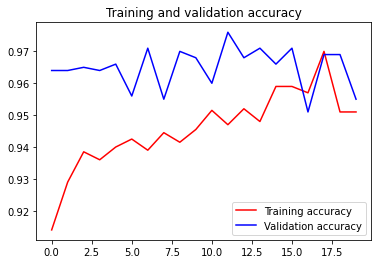

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Visualize loss vs validation loss

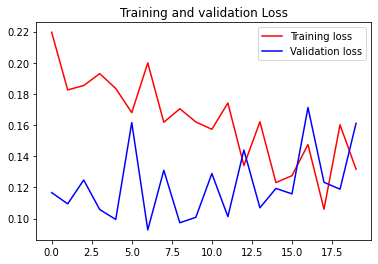

<Figure size 432x288 with 0 Axes>

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()